# Tutorial for using the Fitness Landscape Sequence Design Simulator

* [Building oracles for landscapes](#section-one)
* [Building a model of the landscape](#section-two)
* [Exploring a landscape with a model](#section-three)
* [Evaluating an exploration algorithm](#section-four)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
import flexs
from flexs import baselines
import flexs.utils.sequence_utils as s_utils

## 1. Building oracles for landscapes <a class="anchor" id="section-one"></a>

In [11]:
problem = flexs.landscapes.rna.registry()['L14_RNA1+2']
problem

{'params': {'targets': ['GAACGAGGCACAUUCCGGCUCGCCCGGCCCAUGUGAGCAUGGGCCGGACCCCGUCCGCGCGGGGCCCCCGCGCGGACGGGGGCGAGCCGGAAUGUGCCUC',
   'GAGGCACAUUCCGGCUCGCCCCCGUCCGCGCGGGGGCCCCGCGCGGACGGGGUCCGGCCCGCGCGGGGCCCCCGCGCGGGAGCCGGAAUGUGCCUCGUUC'],
  'seq_length': 14},
 'starts': ['AUGGGCCGGACCCC',
  'GCCCCGCCGGAAUG',
  'UCUUGGGGACUUUU',
  'GGAUAACAAUUCAU',
  'CCCAUGCGCGAUCA']}

In [56]:
wt = problem['starts'][2]
wt

'UCUUGGGGACUUUU'

In [57]:
landscape = flexs.landscapes.RNABinding(**problem['params'])

You can now query the landscape for ground truth sequence fitnesses

In [58]:
landscape.get_fitness([wt])

array([0.27879076])

While we show this process on RNA landscapes there are other empirical landscapes that we have similar wrappers around. You can also make your own *custom* landscapes, but making RNA landcsapes with different targets, or a combination of targets (see the RNA_landscape_model_constructor for examples of how these can be made). 

In [26]:
rosetta_problem = flexs.landscapes.rosetta.registry()['3msi.pdb']
rosetta_problem

{'params': {'pdb_file': '/Users/stewartslocum/Downloads/FLSD-Sandbox/flexs/landscapes/data/rosetta/3msi.pdb'}}

In [27]:
protein_landscape = flexs.landscapes.RosettaFolding(**rosetta_problem['params'],
                                                    sigmoid_center=10,
                                                    sigmoid_norm_value=12)

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.mac.python37.Release 2020.02+release.22ef835b4a2647af94fcd6421a85720f07eddf12 2020-01-05T17:31:56] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [28]:
protein_wt = protein_landscape.wt_pose.sequence()
protein_wt

'MAQASVVANQLIPINTHLTLVMMRSEVVTPVGIPAEDIPRLVSMQVNRAVPLGTTLMPDMVKGYAA'

In [29]:
protein_landscape.get_fitness([protein_wt])

array([0.4904483], dtype=float32)

In [30]:
bert_gfp_landscape = flexs.landscapes.BertGFPBrightness()

In [31]:
gfp_sequence = "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVT" \
               "TLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIE" \
               "LKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNT" \
               "PIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

bert_gfp_landscape.get_fitness([gfp_sequence])

array([3.57247734])

In [32]:
tf_binding_problem = flexs.landscapes.tf_binding.registry()['VAX2_REF_R2']
tf_binding_problem

{'params': {'landscape_file': '/Users/stewartslocum/Downloads/FLSD-Sandbox/flexs/landscapes/data/tf_binding/VAX2_REF_R2_8mers.txt'}}

In [33]:
tf_binding_landscape = flexs.landscapes.TFBinding(**tf_binding_problem['params'])

In [34]:
tf_binding_landscape.get_fitness(["CGTATCAA"])

array([0.45653133])

In [36]:
additive_aav_problem = flexs.landscapes.additive_aav_packaging.registry()['liver']
additive_aav_problem

{'params': {'phenotype': 'liver', 'start': 450, 'end': 540}}

In [54]:
additive_aav_landscape = flexs.landscapes.AdditiveAAVPackaging(**additive_aav_problem['params'])

In [55]:
additive_aav_landscape.get_fitness([additive_aav_landscape.wild_type])

array([0.5])

## 2. Building a model of the landscape <a class="anchor" id="section-two"></a>

In reality, you don't have access to the ground truth landscape oracles except through costly experiments. Instead you can access an approximate version of it either by modeling the landscape through your current observations. In section 2.1 we use an abstract model to simulate the situation where you have a model with arbitrary noise. In section 2.2 we show some standard neural nets and use them as models of the landscape. It is easy to implement your own model. All they need to do is to implement `_fitness_function(sequence)` which gives you the model's estimate of a sequences fitness, and `update_model([sequence1, sequence2,...])` which will pay a cost to learn on the true labels of sequences.

### 2.1. Null model

The null model is the most simple model of the landscape. At each epoch, the model guesses the fitness of a variant by drawing a random sample from the exponential distribution $\lambda e^{-\lambda x}$, with $\lambda = \mathbb{E}[f_\text{measured_sequences}]$. 

In [112]:
null_model = baselines.models.NullModel()

We want to "measure" the true fitness of at least one sequence to start with (otherwise we can't have a model). We can do that by calling `measure_true_landscape` on the noisy model. This will charge you a "measurment cost", but in return tells you the true fitness of the sequence. When starting out or reusing the landscape, `reset` lets you zero the cost in the landscape, and if you pass it any sequences, it will measure those.  

let's ask it for the fitness of a random sequence (we will show more complex results later).

In [114]:
null_model.get_fitness([wt]), landscape.get_fitness([wt])

(array([0.05381277]), array([0.58446259]))

### 2.2 Abstract model 

This is an abstract model that "emulates" a real model of the landscape. It works by guessing the fitness of a new sequence as a combination of it's real fitness and fitness of the closest known neighbor. 

To build a noisy model, you need to have an oracle, and a `signal_strength` $\alpha \in [0,1]$. This parameter $\alpha$ determines how much your oracle signal is corrupted by noise:

$f_{model}= \alpha^d f_{oracle} + (1-\alpha^d)\epsilon$

here $d$ is the distance to the closest measured neighbor, and $\epsilon$ is a sample from an exponential distribution $\lambda e^{-\lambda x}$, with $\lambda = f_\text{closest_neighbor}$ (for each queried sample, this is sampled once and then fixed for that batch). 

In [64]:
noisy_models = [baselines.models.NoisyAbstractModel(landscape, signal_strength=ss) for ss in [1, 0.9, 0.75, 0]]
for model in noisy_models:
    model.train([wt], landscape.get_fitness([wt]))

Let's measure the fitness of some samples through the model

In [65]:
val_x = np.array(list(s_utils.generate_random_mutant(wt, 0.2*(i%5), alphabet=s_utils.RNAA)
                  for i in range(1000)))
val_y = landscape.get_fitness(val_x)

noisy_preds = noisy_models[2].get_fitness(val_x[:5])
list(zip(val_x[:5], noisy_preds))

[('UCUUGGGGACUUUU', 0.27879076194752395),
 ('UCUUGGGGACUUUU', 0.27879076194752395),
 ('UCUUCGGCAUUUUU', 0.3126059087759364),
 ('CAUACGGGACUUUU', 0.18602226195565102),
 ('UUUUGGCACCUCGU', 0.13489461920438992)]

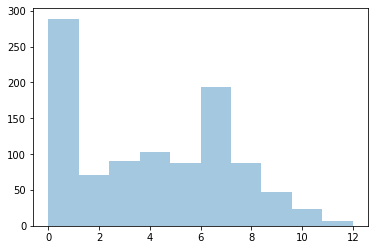

In [66]:
distances = [editdistance.eval(seq, wt) for seq in val_x]

sns.distplot(distances, kde=False)
plt.show()

In [67]:
import scipy.stats

def get_corr_per_distance(seqs, labels, preds):    
    corrs = []
    edit_distances = np.array([editdistance.eval(seq, wt) for seq in seqs])
    
    for dist in range(1, 11):
        seqs_at_dist = edit_distances == dist
        
        if seqs_at_dist.sum() > 50:
            corrs.append(
                scipy.stats.pearsonr(labels[seqs_at_dist], preds[seqs_at_dist])[0]**2
            )
        else:
            corrs.append(np.nan)
            
    return corrs

In [68]:
corrs_noisy_neighbors = [get_corr_per_distance(val_x, val_y, noisy_model.get_fitness(val_x))
                         for noisy_model in noisy_models]
corrs_null = get_corr_per_distance(val_x, val_y, null_model.get_fitness(val_x))

NameError: name 'null_model' is not defined

In [ ]:
plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(1,11), corrs_noisy_neighbors[0], 'o-', label="$\phi'_{1}$")
plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")
plt.plot(range(1,11), corrs_noisy_neighbors[2], 'o-', label="$\phi'_{0.5}$")
plt.plot(range(1,11), corrs_noisy_neighbors[3], 'o-', label="$\phi'_{0.0}$")
plt.plot(range(1,11), corrs_null, 'o-', label="null")
plt.ylabel("$r^2$ between $\phi(x)$ and $\phi'(x)$ ")
plt.xlabel("Distance from wt")
plt.legend()
plt.show()

In [121]:
ensemble = flexs.Ensemble(noisy_models)

ensemble.train([wt], landscape.get_fitness([wt]))

In [122]:
ensemble.get_fitness([wt])

array([0.58446259])

In [123]:
ensemble.combine_with = lambda scores: scores
ensemble.get_fitness([wt])

array([[0.58446259, 0.58446259, 0.58446259, 0.58446259]])

### 2.3 Models of landscapes built from data

Similarly, we can approximate the landscape by training a model on it. Some basic architectures are provided for convenience. 

For real models, it's more sensible to train them on more than just the WT

In [124]:
train_x = np.array(list(set(s_utils.generate_random_mutant(wt, 0.2*(i%5), s_utils.RNAA)
                                 for i in range(0, 20000))))
train_y = landscape.get_fitness(train_x)
print (f'training data consisted of {len(train_x)} unique sequences')

training data consisted of 13259 unique sequences


In [125]:
linear_regression = baselines.models.LinearRegression(alphabet=s_utils.RNAA)
linear_regression.train(train_x, train_y)

linear_regression_preds = linear_regression.get_fitness(val_x)
corrs_linear = get_corr_per_distance(val_x, val_y, linear_regression_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(linear_regression_preds, val_y)[0]**2}")

Overall correlation: 0.8264154316704548


In [126]:
random_forest = baselines.models.RandomForest(alphabet=s_utils.RNAA)
random_forest.train(train_x, train_y)

random_forest_preds = random_forest.get_fitness(val_x)
corrs_rf = get_corr_per_distance(val_x, val_y, random_forest_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(random_forest_preds, val_y)[0]**2}")

Overall correlation: 0.8890330756914995


In [127]:
sequence_length = len(train_x[0])

mlp = baselines.models.MLP(sequence_length, hidden_size=100, alphabet=s_utils.RNAA, loss='MSE')
mlp.train(train_x, train_y)

mlp_preds = mlp.get_fitness(val_x)
corrs_mlp = get_corr_per_distance(val_x, val_y, mlp_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(mlp_preds, val_y)[0]**2}")

Overall correlation: 0.8949673316100673


In [128]:
cnn = baselines.models.CNN(sequence_length, alphabet=s_utils.RNAA, num_filters=32, hidden_size=100, loss='MSE')
cnn.train(train_x, train_y)

cnn_preds = cnn.get_fitness(val_x)
corrs_cnn = get_corr_per_distance(val_x, val_y, cnn_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_preds, val_y)[0]**2}")

Overall correlation: 0.9360624831284087


We can easily ensemble these models of the landscape as well. 

In [129]:
cnn_ensemble = flexs.Ensemble([
    baselines.models.CNN(sequence_length, alphabet=s_utils.RNAA, num_filters=32, hidden_size=100, loss='MSE')
    for i in range(3)
])
cnn_ensemble.train(train_x, train_y)

cnn_ensemble_preds = cnn_ensemble.get_fitness(val_x)
corrs_cnn_ensemble = get_corr_per_distance(val_x, val_y, cnn_ensemble_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_ensemble_preds, val_y)[0]**2}")

Overall correlation: 0.9484967033067727


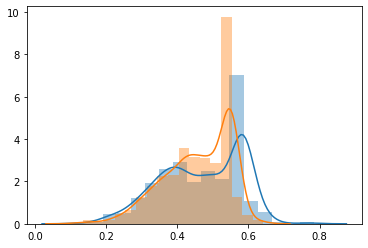

In [130]:
sns.distplot(val_y)
sns.distplot(linear_regression_preds)

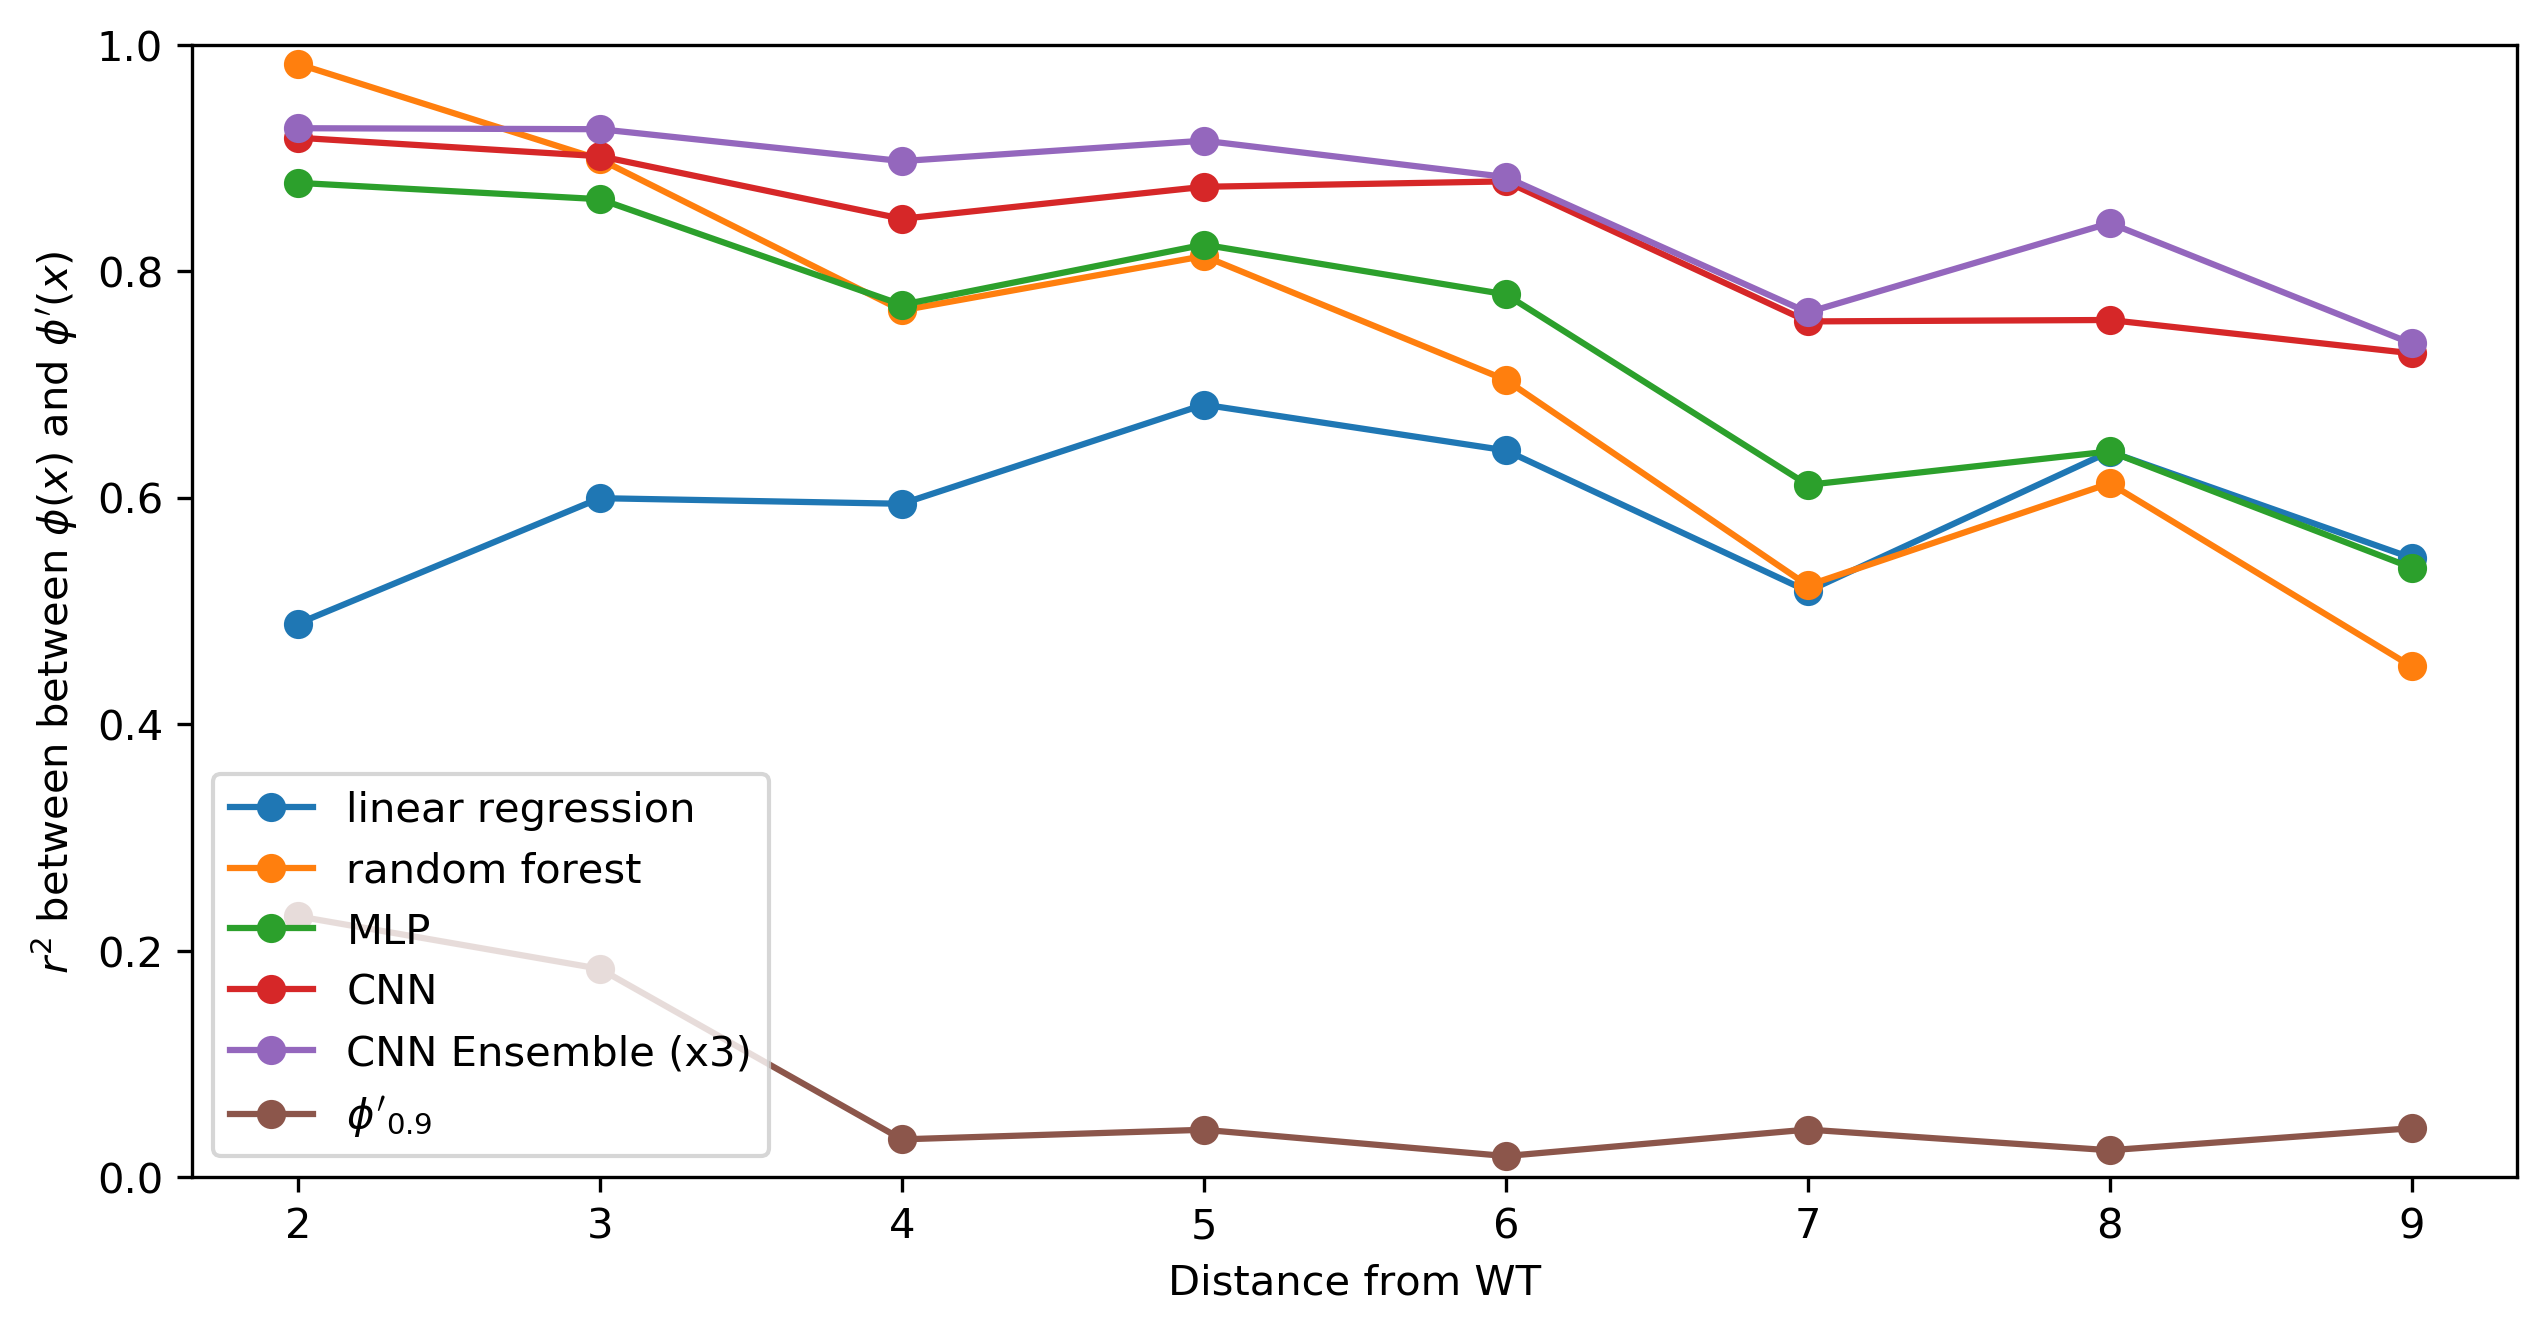

In [131]:
plt.figure(figsize=(10,5), dpi=300)

plt.plot(range(1,11), corrs_linear, 'o-', label="linear regression")
plt.plot(range(1,11), corrs_rf, 'o-', label="random forest")
plt.plot(range(1,11), corrs_mlp, 'o-', label="MLP")
plt.plot(range(1,11), corrs_cnn, 'o-', label="CNN")
plt.plot(range(1, 11), corrs_cnn_ensemble, 'o-', label="CNN Ensemble (x3)")
plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")

plt.ylabel("$r^2$ between between $\phi(x)$ and $\phi'(x)$")
plt.xlabel("Distance from WT")
plt.legend()
plt.ylim(0, 1)
plt.show()

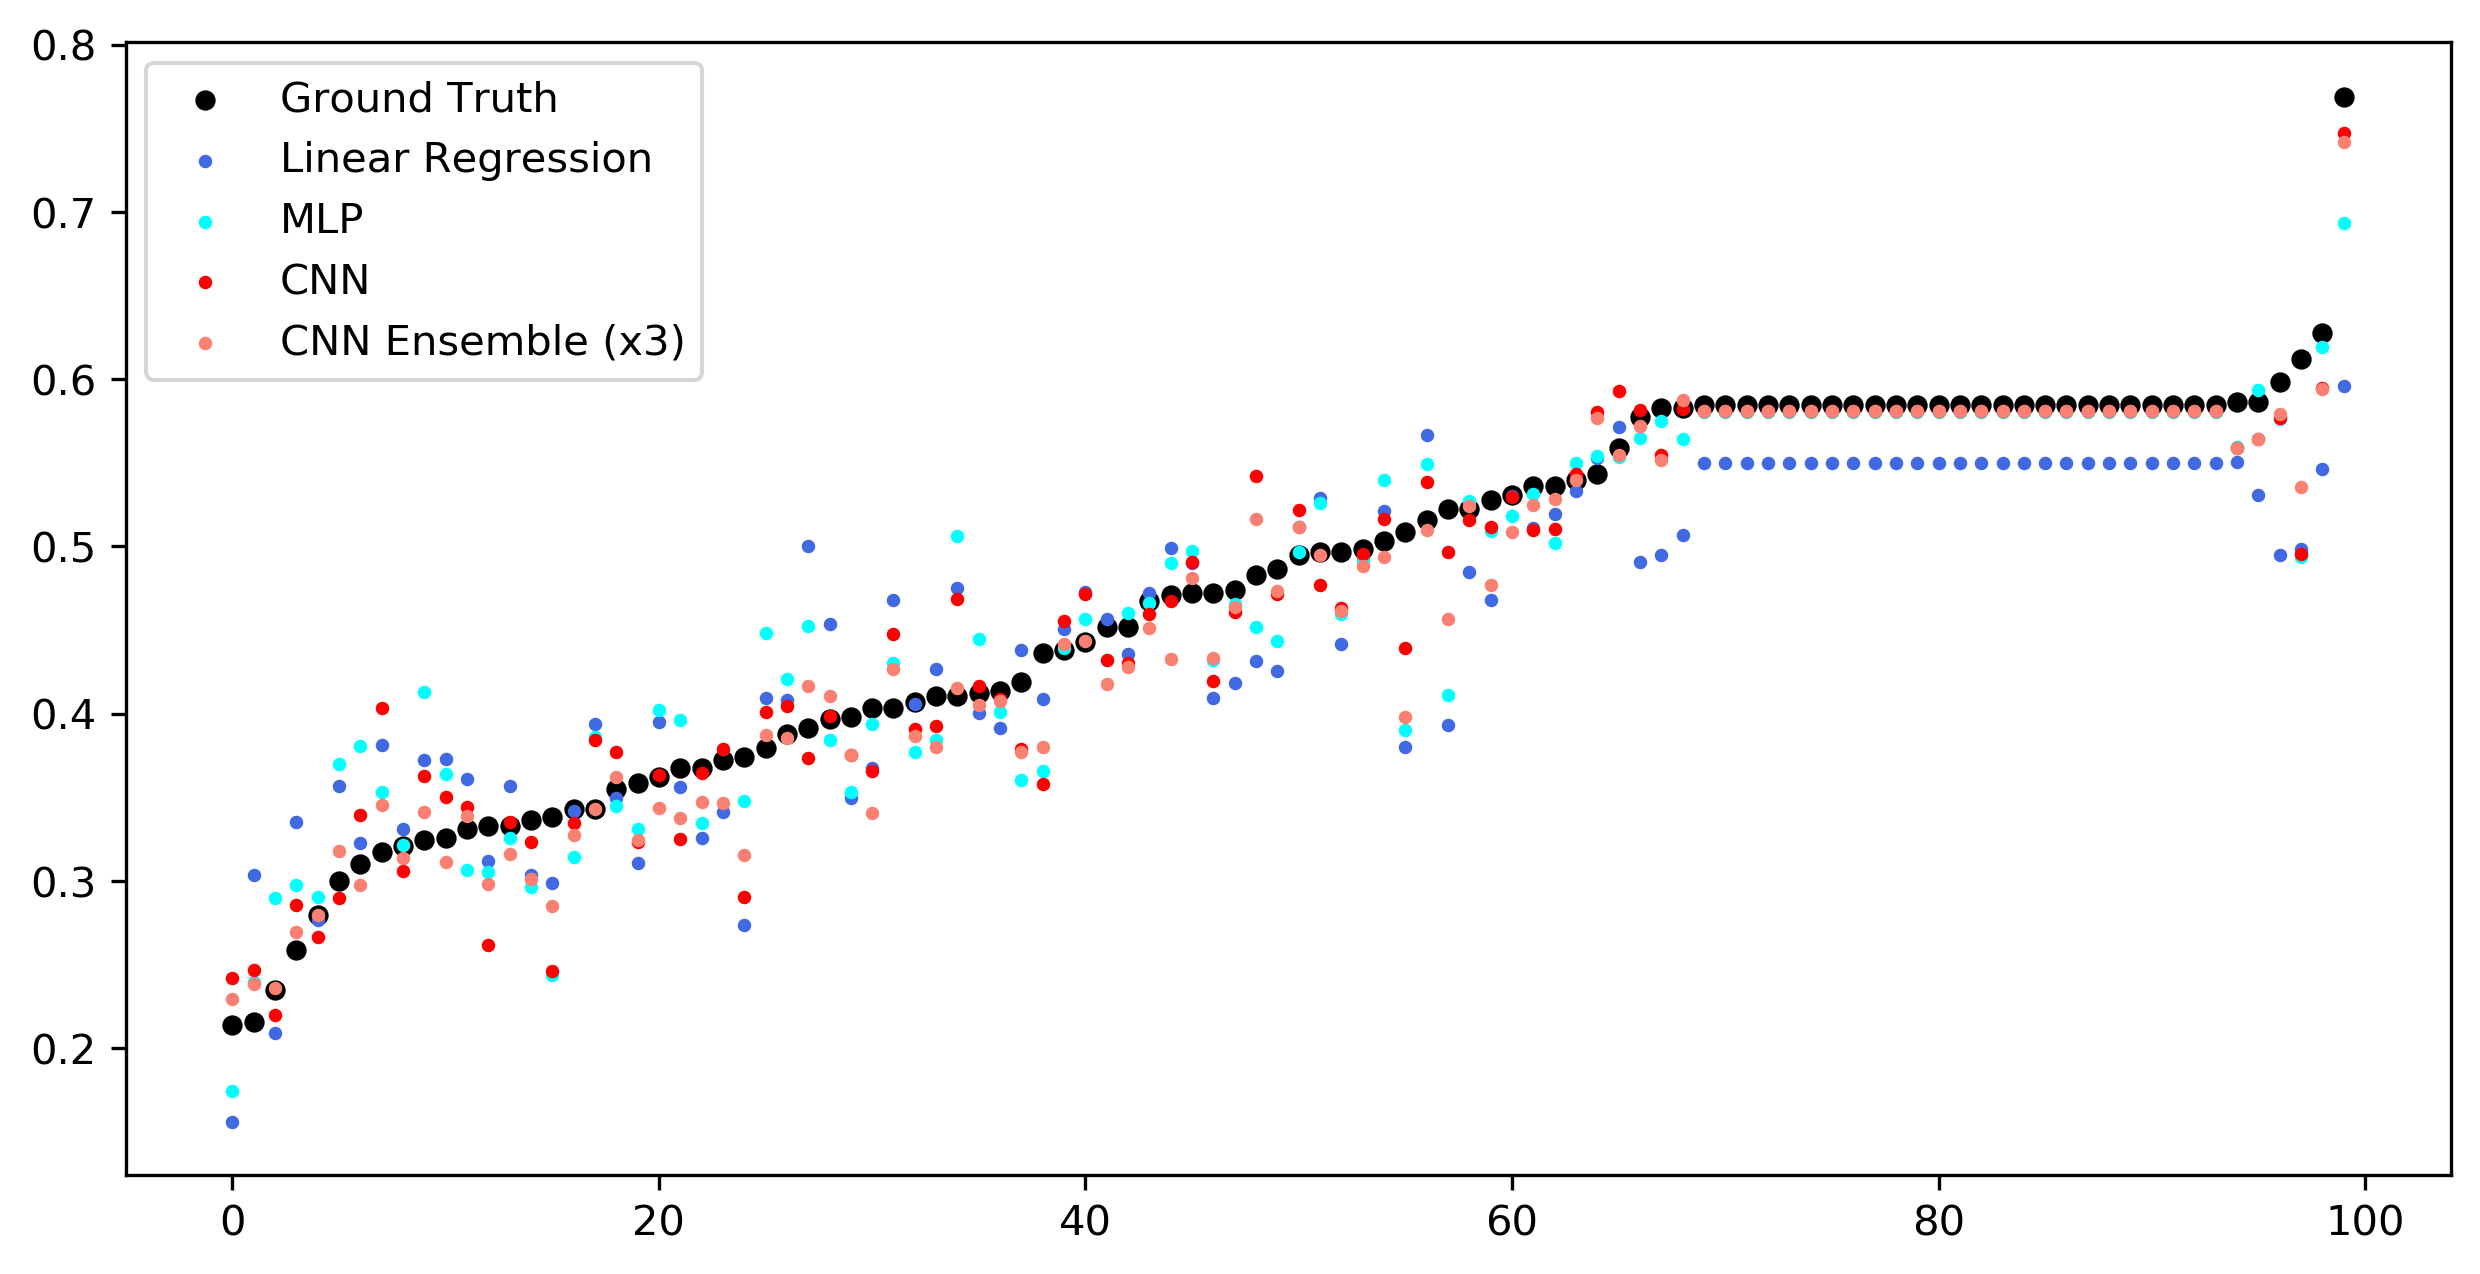

In [132]:
plt.figure(figsize=(10,5), dpi=300)

sort_order = np.argsort(val_y[:100])

plt.scatter(range(len(sort_order)), val_y[sort_order], c="k", s=15, label="Ground Truth")
plt.scatter(range(len(sort_order)), linear_regression_preds[sort_order], c="royalblue", s=5, label="Linear Regression")
plt.scatter(range(len(sort_order)), mlp_preds[sort_order], c="cyan", s=5, label="MLP")
plt.scatter(range(len(sort_order)), cnn_preds[sort_order], c="red", s=5, label="CNN")
plt.scatter(range(len(sort_order)), cnn_ensemble_preds[sort_order], c="salmon", s=5, label="CNN Ensemble (x3)")

plt.legend()
plt.show()

Now that we have models, we can use them with an exploration algorithm to search the landscape. 

## 3. Exploring the landscape with a model <a class="anchor" id="section-three"></a>

All exploration algorithms in this package inherit from `Base_explorer` which performs some house-keeping tasks. We recommend doing the same when you "bring your own" explorer. It's very easy to implement an explorer in this framework, all it needs to implement is a `propose_sequences` method, that suggest new sequences for which a "costly" measurment to the oracle is performed.  

In [59]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

random_explorer = baselines.explorers.Random(
    flexs.LandscapeAsModel(landscape),
    rounds=10,
    mu=1,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

- `sequences_batch_size` denotes the experimental batch size per round
- `model_queries_per_batch` is the number of computational queries to the model that is allowed per round. 
- `alphabet` is the alphabet that is permissive on the current landscape.

In [60]:
random_sequences, metadata = random_explorer.run(landscape)
random_sequences

round: 0, top: 0.27879076194752395
round: 1, top: 0.4661279818211852
round: 2, top: 0.6224021406207076
round: 3, top: 0.6224021406207076
round: 4, top: 0.6224021406207076
round: 5, top: 0.6224021406207076
round: 6, top: 0.6224021406207076
round: 7, top: 0.6224021406207076
round: 8, top: 0.6224021406207076
round: 9, top: 0.6224021406207076
round: 10, top: 0.6224021406207076


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,UCUUGGGGACUUUU,NaN,0.278791,0,0,1
0,UGUUGGGGAGUUUG,0.353845,0.353845,1,1001,101
1,GCCUGGGGACUUUG,0.412240,0.412240,1,1001,101
2,UCCUGGGUAAUUUU,0.267858,0.267858,1,1001,101
3,UCUUGCGGAUAUUU,0.304465,0.304465,1,1001,101
...,...,...,...,...,...,...
95,UCAGGUUGAAUUCU,0.219307,0.219307,10,10010,1001
96,UGUUAGGGUGUUAA,0.231717,0.231717,10,10010,1001
97,UCUUGGAGCGCGAA,0.388043,0.388043,10,10010,1001
98,ACUUCGGGCCGCAG,0.405323,0.405323,10,10010,1001


Let's see what was printed:
- The number of **rounds** represents how many experiments was done
- The **cost** shows how many total calls to the oracle was made (experimental cost). Because training the model had an overhead, that is accounted in the total cost. 
- The **evals** shows how many total calls to the model was made (computational cost).
- **Top** simply lists the top fitness (cumulative) observed through the exploration

In [62]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

adalead_explorer = baselines.explorers.Adalead(
    flexs.LandscapeAsModel(landscape),
    rounds=10,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

In [63]:
adalead_sequences, metadata = adalead_explorer.run(landscape)
adalead_sequences

round: 0, top: 0.27879076194752395
round: 1, top: 0.6867563969235371
round: 2, top: 0.8433413941499475
round: 3, top: 0.9618942219948434
round: 4, top: 0.9996155015582209
round: 5, top: 0.9996155015582209
round: 6, top: 0.9996155015582209
round: 7, top: 0.9996155015582209
round: 8, top: 0.9996155015582209
round: 9, top: 0.9996155015582209
round: 10, top: 1.0319481003143287


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,UCUUGGGGACUUUU,NaN,0.278791,0,0,1
0,UCCGGCCGCGGGGU,0.686756,0.686756,1,1200,100
1,CGCGCUGCGGGGGU,0.667481,0.667481,1,1200,100
2,GCGUGGGGUCUCUC,0.665694,0.665694,1,1200,100
3,UGCCGGGCGCCGGU,0.656989,0.656989,1,1200,100
...,...,...,...,...,...,...
94,AGCGCGGGCCCCGC,0.800231,0.800231,10,19100,991
95,GCGGGGGCACCGCC,0.800231,0.800231,10,19100,991
96,GACCCCGCGCGGGC,0.799610,0.799610,10,19100,991
97,GGCCCCGCGCGAGC,0.798495,0.798495,10,19100,991


In [46]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

genetic_explorer = baselines.explorers.GeneticAlgorithm(
    flexs.LandscapeAsModel(landscape),
    
    population_size=20,
    parent_selection_strategy='wright-fisher', # roughly corresponds to who gets to mate
    beta=0.01,
    children_proportion=0.25,

    rounds=10,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

In [47]:
genetic_algo_sequences, metadata = genetic_explorer.run(landscape)
genetic_algo_sequences

round: 0, top: 0.15601505842016555
round: 1, top: 1.0319481003143287
round: 2, top: 1.0319481003143287
round: 3, top: 1.0319481003143287
round: 4, top: 1.0319481003143287
round: 5, top: 1.0319481003143287
round: 6, top: 1.0319481003143287
round: 7, top: 1.0319481003143287
round: 8, top: 1.0319481003143287
round: 9, top: 1.0319481003143287
round: 10, top: 1.0319481003143287


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,GGAUAACAAUUCAU,NaN,0.156015,0,0,1
0,GCGCGGGGGCCCCG,1.031948,1.031948,1,980,100
1,GCGCGGGGGCCCCA,1.002310,1.002310,1,980,100
2,GCGCGGGGGCCCCU,0.999616,0.999616,1,980,100
3,GCGCGGGGGCCCCC,0.991532,0.991532,1,980,100
...,...,...,...,...,...,...
94,GCGCCAGGGCCCCG,0.751732,0.751732,10,9800,991
95,CCGCGGGGGCACCC,0.751732,0.751732,10,9800,991
96,GUGCGGGGGGCUCA,0.751732,0.751732,10,9800,991
97,CCGGGCGGGCCGUG,0.750515,0.750515,10,9800,991


In [41]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

cmaes_explorer = baselines.explorers.CMAES(
    flexs.LandscapeAsModel(landscape),
    
    population_size=10,
    max_iter=200,
    
    rounds=10,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

In [42]:
cmaes_sequences, metadata = cmaes_explorer.run(landscape)
cmaes_sequences

round: 0, top: 0.15601505842016555
round: 1, top: 0.21080944488954523
round: 2, top: 0.34716069886962264
round: 3, top: 0.34716069886962264
round: 4, top: 0.34716069886962264
round: 5, top: 0.34716069886962264
round: 6, top: 0.34716069886962264
round: 7, top: 0.41584151251497314
round: 8, top: 0.41584151251497314
round: 9, top: 0.5047561072088749
round: 10, top: 0.5047561072088749


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,GGAUAACAAUUCAU,NaN,0.156015,0,0,1
0,GGAUACCAAUUCAU,0.210809,0.210809,1,104,100
1,UAAUAUCAUUCCUU,0.210162,0.210162,1,104,100
2,AAAUAUCAUUCCUU,0.210162,0.210162,1,104,100
3,GGAUAACAAGUCAU,0.198918,0.198918,1,104,100
...,...,...,...,...,...,...
94,AGAAACAUCUAGUU,0.126636,0.126636,10,2026,991
95,ACAAAUAUAGAGUU,0.123942,0.123942,10,2026,991
96,AGAAAAAUAGAGUU,0.123942,0.123942,10,2026,991
97,ACAACAAUAGAGUU,0.123942,0.123942,10,2026,991


In [33]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

ppo_explorer = baselines.explorers.PPO(
    flexs.LandscapeAsModel(landscape),
    rounds=10,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

In [34]:
ppo_sequences, metadata = ppo_explorer.run(landscape)
ppo_sequences

round: 0, top: 0.15601505842016555
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
round: 1, top: 0.8400252741100387
round: 2, top: 0.9027732524873182
round: 3, top: 0.9027732524873182
round: 4, top: 0.9027732524873182
round: 5, top: 0.9027732524873182
round: 6, top: 0.9027732524873182
round: 7, top: 0.9699773459882459
round: 8, top: 1.0238649763209262
round: 9, top: 1.0238649763209262
round: 10, top: 1.0238649763209262


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,GGAUAACAAUUCAU,NaN,0.156015,0,0,1
0,GGGCCCCGGUGGGC,0.840025,0.840025,1,1001,100
1,GGGCCCCGCGUCGG,0.816346,0.816346,1,1001,100
2,GGGCCCCGCAUGGG,0.783547,0.783547,1,1001,100
3,GGGCCCCGGUGGGG,0.779272,0.779272,1,1001,100
...,...,...,...,...,...,...
94,AGCACGGGAGCUCC,0.735566,0.549654,10,10011,991
95,AGCGCUGGGGCCCA,0.735566,0.735566,10,10011,991
96,GGCUCGGGGGGCCU,0.734556,0.734556,10,10011,991
97,AGCGCGGGGACCCG,0.732872,0.724789,10,10011,991


In [23]:
dynappo_explorer = baselines.explorers.DynaPPO(
    rounds=5,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

TypeError: __init__() got multiple values for argument 'rounds'

In [24]:
dynappo_sequences, metadata = dynappo_explorer.run(landscape)
dynappo_sequences

NameError: name 'dynappo_explorer' is not defined

In [39]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

vae = baselines.explorers.VAE(len(wt), alphabet=s_utils.RNAA, epochs=2, verbose=False)

cbas_explorer = baselines.explorers.CbAS(
    flexs.LandscapeAsModel(landscape),
    vae,

    rounds=10,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA,
)

In [40]:
cbas_sequences, metadata = cbas_explorer.run(landscape)
cbas_sequences

round: 0, top: 0.15601505842016555


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 1, top: 0.5968573029520681
round: 2, top: 0.6266768702280845
round: 3, top: 0.6266768702280845
round: 4, top: 0.6266768702280845
round: 5, top: 0.6266768702280845
round: 6, top: 0.6266768702280845
round: 7, top: 0.6266768702280845
round: 8, top: 0.6465997383450318
round: 9, top: 0.6465997383450318
round: 10, top: 0.6465997383450318


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,GGAUAACAAUUCAU,NaN,0.156015,0,0,1
0,GGCUUCCCCUGUCA,0.596857,0.596857,1,1000,100
1,CGACCUCCGUUCGC,0.591805,0.591805,1,1000,100
2,GGCAGCCCCGUUCA,0.583308,0.583308,1,1000,100
3,GGCAACCCCGUUCA,0.569732,0.569732,1,1000,100
...,...,...,...,...,...,...
94,UCCUCCGUCUAUCG,0.394105,0.394105,10,10000,991
95,UCUCGUUCUGGGAU,0.393328,0.393328,10,10000,991
96,CCAUGCUCUGUGAU,0.393147,0.393147,10,10000,991
97,UAAAGCGCUGGGUU,0.392913,0.392913,10,10000,991


In [15]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

dqn_explorer = baselines.explorers.DQN(
    cnn,
    
    rounds=5,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

In [ ]:
dqn_sequences, metadata = dqn_explorer.run(landscape)
dqn_sequences

round: 0, top: 1.1689251877114897
round: 1, top: 1.2034067570585447


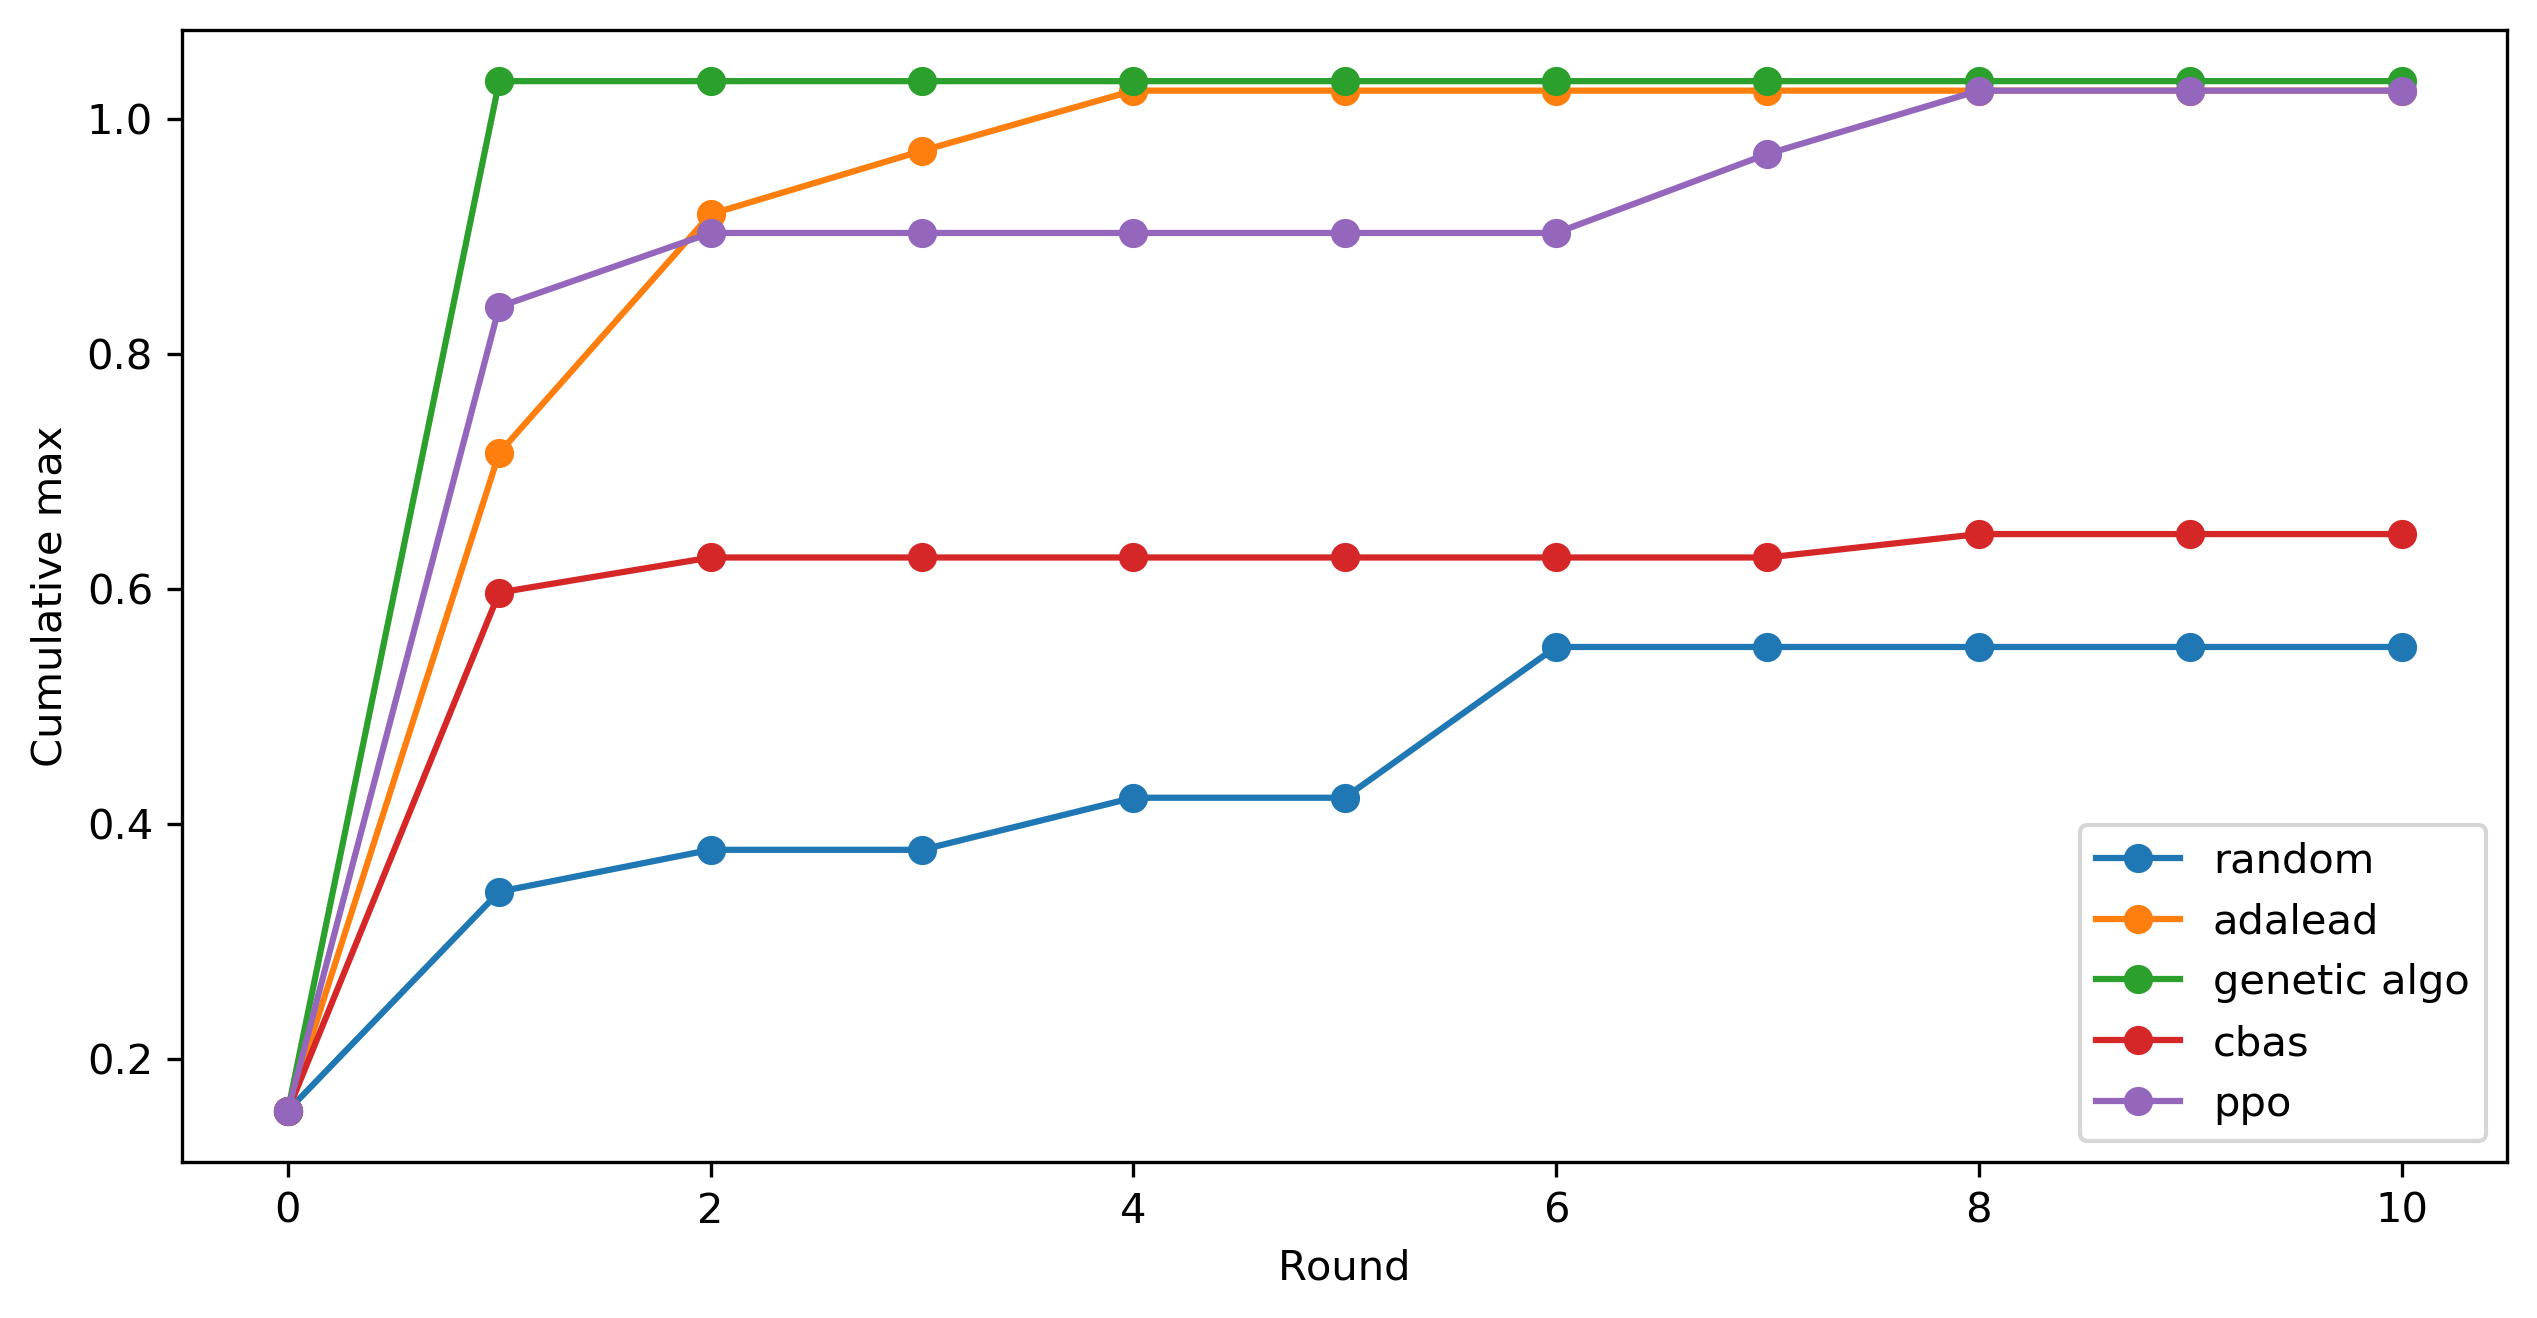

In [48]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)

plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(11), cumulative_max_per_round(random_sequences), 'o-', label="random")
plt.plot(range(11), cumulative_max_per_round(adalead_sequences), 'o-', label="adalead")
plt.plot(range(11), cumulative_max_per_round(genetic_algo_sequences), 'o-', label="genetic algo")
plt.plot(range(11), cumulative_max_per_round(cbas_sequences), 'o-', label="cbas")
plt.plot(range(11), cumulative_max_per_round(ppo_sequences), 'o-', label="ppo")
plt.ylabel("Cumulative max")
plt.xlabel("Round")
plt.legend()
#plt.ylim(0, 1)
plt.show()

## 4. Evaluating an exploration algorithm <a class="anchor" id="section-four"></a>


Pick the landscapes you want to run the evaluation suite on. This can be done by including indexes or "all" which results in loading all pre-defined landscapes. 

**WARNING**: Running evaluators on all landscapes would take forever if not done in a parallel fashion. Debug your process with a couple of landscapes first. We recommend sending each evaluation-landscape pair to a separate worker.  

The evaluator can run tests aimed at different properties of the explorer. 

The tests include:
- `consistency_robustness_independence`: shows how explorer performance changes given different models.
- `efficiency`: shows how explorer performance changes when more computational evals are allowed
- `adaptivity`: shows how the explorer is sensitive to the number of batches it is allowed to sample
- `scalability`: shows how fast the explorer produces a batch. 

Note that once you run a particular test (among these), if you want to run more tests, you need to re-run `load_landscapes` on the evaluator (as the generator stack is depleted.  

In [141]:
def make_explorer(model, ss):
    return baselines.explorers.Random(
            model,
            landscape,
            rounds=5,
            mu=1,
            starting_sequence=wt,
            sequences_batch_size=100,
            model_queries_per_batch=1000,
            alphabet=s_utils.RNAA
        )

results = flexs.evaluate.robustness(landscape, make_explorer)

Evaluating for robustness to model accuracy; signal_strength: 0
round: 0, top: 0.5844625938557448
round: 1, top: 0.6482534774172843
round: 2, top: 0.7137684789072011
round: 3, top: 0.7172166489955815
round: 4, top: 0.7344574336691089
round: 5, top: 0.7620426957235903
Evaluating for robustness to model accuracy; signal_strength: 0.5
round: 0, top: 0.5844625938557448
round: 1, top: 0.7275611263765354
round: 2, top: 0.6827350796485264
round: 3, top: 0.7327333486249188
round: 4, top: 0.7051480865704374
round: 5, top: 0.7085962566588176
Evaluating for robustness to model accuracy; signal_strength: 0.8
round: 0, top: 0.5844625938557448
round: 1, top: 0.7120443938630109
round: 2, top: 0.7275610934923483
round: 3, top: 0.7706630880603541
round: 4, top: 0.7430778260058727
round: 5, top: 0.782731617601311
Evaluating for robustness to model accuracy; signal_strength: 0.9
round: 0, top: 0.5844625938557448
round: 1, top: 0.7689390030161639
round: 2, top: 0.781007565441308
round: 3, top: 0.818937271